# Predicting Anime Success: A Hands-On Data Regression Project

In this project I will build a regression Machine Learning model that predicts an Anime's ranking based on features such as popularity, score, genres, members, and the number of users who favorited it. The dataset I selected contains anime information scraped as of July 2025 ([kaggle link](https://www.kaggle.com/datasets/hamzaashfaque1999/myanimelist-scraped-data)). When downloaded there are two CSV files: `anime_entries.csv` and `manga_entries.csv`. In this project we will use `anime_entries.csv`.

## 1. Data Preparation
Before we start, let's import the necessary libraries.
### 1.1 Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

### 1.2 Data Formatting
#### 1.2.1 Load Dataset

In [2]:
df = pd.read_csv('anime_entries.csv')
print(df.info())
print(df.sample(5))
print(df.sample(5)[['producers', 'themes', 'airing_date', 'premier_date', 'producers', 'duration']])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28635 entries, 0 to 28634
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              28635 non-null  int64  
 1   link            28635 non-null  object 
 2   title_name      28635 non-null  object 
 3   score           18673 non-null  float64
 4   scored_by       28635 non-null  int64  
 5   ranked          21857 non-null  float64
 6   popularity      28635 non-null  int64  
 7   members         28635 non-null  int64  
 8   favorited       28635 non-null  int64  
 9   synonymns       14159 non-null  object 
 10  japanese_name   28517 non-null  object 
 11  english_name    12313 non-null  object 
 12  german_name     2002 non-null   object 
 13  french_name     2177 non-null   object 
 14  spanish_name    2055 non-null   object 
 15  item_type       28635 non-null  object 
 16  episodes        28635 non-null  object 
 17  status          28635 non-null 

From the `df.info()` output, several columns contain missing values. Before handling missing values we will continue with data formatting.

There are unexpected data types in these columns:
1. `episodes` (should be `int64` but is `object`)
2. `airing_date` (should be a `date` but is `object`). The `airing_date` column contains mixed formats such as `Dec 24, 2000 to Dec 31, 2000`, `2020`, `Apr 16, 2010`, etc. I will standardize to `Month Day, Year` formats.

#### 1.2.2 Check Duplicates

In [3]:
df.duplicated().sum()

np.int64(0)

Because there are no duplicate rows, no action is required.

#### 1.2.3 Adjust data types for `episodes` and `airing_date` columns

In [4]:
# 1. `episodes` (should be `int64` but currently `object`)
df["episodes"] = pd.to_numeric(df["episodes"], errors="coerce").astype("Int64")

# 2. `airing_date` (should be `date` but currently `object`)
def clean_airing_date(x):
    if pd.isna(x):
        return np.nan
    # Keep only the first part of formats like "Dec 24, 2000 to Dec 31, 2000"
    if "to" in str(x):
        x = str(x).split("to")[0].strip()
    try:
        return pd.to_datetime(x, errors="coerce")
    except:
        return np.nan

df["airing_date"] = df["airing_date"].apply(clean_airing_date)

# Check
print(df[["episodes", "airing_date"]].dtypes)
print(df[["episodes", "airing_date"]].sample(5))

episodes                Int64
airing_date    datetime64[ns]
dtype: object
       episodes airing_date
2621         12  2025-04-01
14986         1  2014-08-30
8746         48  1970-11-02
26815         1  1999-12-01
10134         1  1994-10-08


The `airing_date` column now has dtype `datetime64[ns]`.

Next, some columns contain lists but are currently interpreted as single strings:
1. `genres`
2. `producers`
3. `studios`
4. `themes`

We need to convert these columns to lists first.

#### 1.2.4 Adjust data types for `genres`, `producers`, `studios`, and `themes` columns

In [5]:
import ast

list_columns = ["genres", "producers", "studios", "themes"]

def to_list(x):
    try:
        return ast.literal_eval(str(x)) if pd.notna(x) and str(x).strip() != "" else []
    except:
        return []

for col in list_columns:
    df[col] = df[col].apply(to_list)

# Check results
for col in list_columns:
    print(f"{col} example:", df[col].iloc[0], type(df[col].iloc[0]))

genres example: ['Adventure', 'Drama', 'Fantasy'] <class 'list'>
producers example: ['Aniplex', 'Dentsu', 'Shogakukan-Shueisha Productions', 'Nippon Television Network', 'TOHO animation', 'Shogakukan'] <class 'list'>
studios example: ['Madhouse'] <class 'list'>
themes example: [] <class 'list'>


Before using algorithms like `MultiLabelBinarizer` or `One-Hot Encoder` to expand these lists into atomic columns, I want to check whether there are empty lists in the data.

In [6]:
list_columns = ["genres", "producers", "studios", "themes"]

for col in list_columns:
    empty_count = df[col].apply(lambda x: isinstance(x, list) and len(x) == 0).sum()
    total = len(df)
    print(f"{col}: {empty_count} empty rows out of {total} ({empty_count/total:.2%})")


genres: 5926 empty rows out of 28635 (20.69%)
producers: 15130 empty rows out of 28635 (52.84%)
studios: 11596 empty rows out of 28635 (40.50%)
themes: 11775 empty rows out of 28635 (41.12%)


It turns out `producers`, `studios`, and `themes` have empty lists (missing values) of approximately 50%. We will not bother with doing list expansion for these columns because they will be dropped during missing value handling.

For the `genres` column, we can use `MultiLabelBinarizer` to convert lists into `One-Hot Encoder` columns.

#### 1.2.5 Expand `genres` lists into binary columns using `MultiLabelBinarizer`

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
encoded_genres = mlb.fit_transform(df['genres'])
df_genres_encoded = pd.DataFrame(encoded_genres, columns=mlb.classes_)

print(df_genres_encoded.sample(5))
print(df_genres_encoded.info())

df = pd.concat([df, df_genres_encoded], axis=1)
df.drop(columns=['genres'], inplace=True)

df.info()
df.sample(3)

       Action  Adventure  Avant Garde  Award Winning  Boys Love  Comedy  \
14862       0          0            0              0          0       0   
24124       0          0            0              0          0       0   
13644       0          0            0              0          0       0   
5077        1          1            0              0          0       1   
24235       0          0            0              0          0       0   

       Drama  Ecchi  Erotica  Fantasy  ...  Gourmet  Hentai  Horror  Mystery  \
14862      1      0        0        0  ...        0       0       0        0   
24124      0      0        0        0  ...        0       0       0        0   
13644      0      0        0        0  ...        0       0       0        0   
5077       0      0        0        1  ...        0       0       0        0   
24235      0      0        0        0  ...        0       0       0        0   

       Romance  Sci-Fi  Slice of Life  Sports  Supernatural  Suspens

,id,link,title_name,score,scored_by,ranked,popularity,members,favorited,synonymns,...,Gourmet,Hentai,Horror,Mystery,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Suspense
18417,52958,https://myanimelist.net/anime/52958/Forest_and...,Forest and Trees,NaN,0,18431.0,22896,168,0,NaN,...,0,0,0,0,0,0,0,0,0,0
4012,1826,https://myanimelist.net/anime/1826/Deltora_Quest,Deltora Quest,7.1,13240,3989.0,4332,31525,224,NaN,...,0,0,0,0,0,0,0,0,0,0
15899,43633,https://myanimelist.net/anime/43633/Xiang_Hu,Xiang Hu,NaN,0,15912.0,26173,93,0,NaN,...,0,0,0,0,0,0,0,0,0,0


### 1.3 Handling Missing Values

#### 1.3.1 Drop problematic columns

First, we check which columns have more than 50% missing values (threshold).

In [8]:
df.info()
# Set a threshold of 50% missing values
threshold = len(df) * 0.5

# Find columns with non-null counts below the threshold
missing_cols = df.columns[df.isnull().sum() > threshold]

print("Columns with more than 50% missing values:")
print(missing_cols.tolist())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28635 entries, 0 to 28634
Data columns (total 52 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              28635 non-null  int64         
 1   link            28635 non-null  object        
 2   title_name      28635 non-null  object        
 3   score           18673 non-null  float64       
 4   scored_by       28635 non-null  int64         
 5   ranked          21857 non-null  float64       
 6   popularity      28635 non-null  int64         
 7   members         28635 non-null  int64         
 8   favorited       28635 non-null  int64         
 9   synonymns       14159 non-null  object        
 10  japanese_name   28517 non-null  object        
 11  english_name    12313 non-null  object        
 12  german_name     2002 non-null   object        
 13  french_name     2177 non-null   object        
 14  spanish_name    2055 non-null   object        
 15  it

The output shows columns such as `synonymns`, `english_name`, `german_name`, `french_name`, `spanish_name`, `premier_date`, `broadcast_date`, `demographic`, `background` have > 50% missing values. Also, these columns (features) don't effect the predicant (rank). So, these columns can be safely dropped. Also drop `producers`, `studios`, and `themes` because they contain many empty lists.

In [9]:
cols_to_drop = [
    'synonymns', 'english_name', 'german_name', 'french_name', 'spanish_name',
    'premier_date', 'broadcast_date', 'demographic', 'background',
    'producers', 'studios', 'themes'
]

df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28635 entries, 0 to 28634
Data columns (total 40 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             28635 non-null  int64         
 1   link           28635 non-null  object        
 2   title_name     28635 non-null  object        
 3   score          18673 non-null  float64       
 4   scored_by      28635 non-null  int64         
 5   ranked         21857 non-null  float64       
 6   popularity     28635 non-null  int64         
 7   members        28635 non-null  int64         
 8   favorited      28635 non-null  int64         
 9   japanese_name  28517 non-null  object        
 10  item_type      28635 non-null  object        
 11  episodes       27992 non-null  Int64         
 12  status         28635 non-null  object        
 13  airing_date    27767 non-null  datetime64[ns]
 14  licensors      28635 non-null  object        
 15  source         2863

#### 1.3.2 Use regression to fill `score`
Here I use `scored_by`, `popularity`, `members`, and `favorited` as independent variables.

In [10]:
from sklearn.linear_model import LinearRegression

selected_cols = ['score','scored_by', 'popularity', 'members', 'favorited']
# 1. Split the data into two parts: one to train the model (rows with existing `score` values)
#    and one to predict the missing `score` values.
train_data = df[df['score'].isnull() == False][selected_cols]
predict_data = df[df['score'].isnull() == True][selected_cols]

# 2. Define features (X) and target (y).
y_train = train_data['score']
X_train = train_data.drop('score', axis=1)

# 3. Create and train a linear regression model.
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Use the model to predict missing `score` values.
x_missing = predict_data.drop('score', axis=1)
prediction = model.predict(x_missing)
predict_data['score'] = prediction

# 5. Merge training and predicted data back.
# Insert the predicted values into the original df
df.loc[df['score'].isnull(), 'score'] = prediction

# Check
print(df.info())
print("\n")
print(df.sample(5)['score'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28635 entries, 0 to 28634
Data columns (total 40 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             28635 non-null  int64         
 1   link           28635 non-null  object        
 2   title_name     28635 non-null  object        
 3   score          28635 non-null  float64       
 4   scored_by      28635 non-null  int64         
 5   ranked         21857 non-null  float64       
 6   popularity     28635 non-null  int64         
 7   members        28635 non-null  int64         
 8   favorited      28635 non-null  int64         
 9   japanese_name  28517 non-null  object        
 10  item_type      28635 non-null  object        
 11  episodes       27992 non-null  Int64         
 12  status         28635 non-null  object        
 13  airing_date    27767 non-null  datetime64[ns]
 14  licensors      28635 non-null  object        
 15  source         2863

It appears all `score` values are now filled. No more `NaN`.

#### 1.3.3 Use linear regression to fill `ranked`
Here I use `scored_by`, `score`, `popularity`, `members`, and `favorited` as independent variables. Because this is a ranking, I also ensure there are no duplicate ranks.

In [11]:
from sklearn.linear_model import LinearRegression

selected_cols = ['ranked', 'score','scored_by', 'popularity', 'members', 'favorited']
# 1. Split data into two parts: one to train (rows with existing `ranked` values)
#    and one to predict missing `ranked` values.
train_data = df[df['ranked'].isnull() == False][selected_cols]
predict_data = df[df['ranked'].isnull() == True][selected_cols]
print(f"Number of rows with missing 'ranked': {len(predict_data)}")
print(f"Number of rows with filled 'ranked': {len(train_data)}")
print(df.info())

# 2. Define features (X) and target (y).
y_train = train_data['ranked']
X_train = train_data.drop('ranked', axis=1)

# 3. Create and train a linear regression model.
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Use the model to predict missing `ranked` values.
x_missing = predict_data.drop('ranked', axis=1)
prediction = model.predict(x_missing)
predict_data['ranked'] = prediction

# 5. Merge training and predicted data back.
df.loc[df['ranked'].isnull(), 'ranked'] = prediction

# 6. Handle duplicate ranks and ensure uniqueness
# .rank(method='first') assigns a unique rank to each row, breaking ties
# based on the order of appearance in the DataFrame.
df['ranked'] = df['ranked'].rank(method='first')
print("After resolving duplicates with rank(method='first'):")
print(df['ranked'])
print("\n")

# 7. Change the 'ranked' column's data type to int64
df['ranked'] = df['ranked'].astype('int64')



# Check
print(df.info())
print("\n")
print(df.sample(5)['ranked'])

Number of rows with missing 'ranked': 6778
Number of rows with filled 'ranked': 21857
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28635 entries, 0 to 28634
Data columns (total 40 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             28635 non-null  int64         
 1   link           28635 non-null  object        
 2   title_name     28635 non-null  object        
 3   score          28635 non-null  float64       
 4   scored_by      28635 non-null  int64         
 5   ranked         21857 non-null  float64       
 6   popularity     28635 non-null  int64         
 7   members        28635 non-null  int64         
 8   favorited      28635 non-null  int64         
 9   japanese_name  28517 non-null  object        
 10  item_type      28635 non-null  object        
 11  episodes       27992 non-null  Int64         
 12  status         28635 non-null  object        
 13  airing_date    27767 non-null  date

#### 1.3.4 Drop problematic rows
Since the remaining rows with missing values are few, we can drop them.

In [12]:
df_update = df.dropna(axis = 0).reset_index(drop = True)
df_update.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26900 entries, 0 to 26899
Data columns (total 40 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             26900 non-null  int64         
 1   link           26900 non-null  object        
 2   title_name     26900 non-null  object        
 3   score          26900 non-null  float64       
 4   scored_by      26900 non-null  int64         
 5   ranked         26900 non-null  int64         
 6   popularity     26900 non-null  int64         
 7   members        26900 non-null  int64         
 8   favorited      26900 non-null  int64         
 9   japanese_name  26900 non-null  object        
 10  item_type      26900 non-null  object        
 11  episodes       26900 non-null  Int64         
 12  status         26900 non-null  object        
 13  airing_date    26900 non-null  datetime64[ns]
 14  licensors      26900 non-null  object        
 15  source         2690

### 1.4 Normalization

To account for differing feature scales (large magnitudes with similar variance), I standardize the `members` and `scored_by` features by applying `sklearn.preprocessing.StandardScaler()` to produce z-score normalized columns.

In [13]:
normalized_df = df_update[['members', 'scored_by']]
X = np.array(normalized_df['members']).reshape(-1,1)
Y = np.array(normalized_df['scored_by']).reshape(-1,1)

scaler = preprocessing.StandardScaler()

scaler.fit(X)
scaler.fit(Y)
X_scaled = scaler.transform(X)
Y_scaled = scaler.transform(Y)
normalized_df['zscore_sckit_members'] = X_scaled
normalized_df['zscore_sckit_scored_by'] = Y_scaled
print(normalized_df.head())

df_update['zscore_sckit_members'] = normalized_df['zscore_sckit_members']
df_update['zscore_sckit_scored_by'] = normalized_df['zscore_sckit_scored_by']
print(df_update.info())
print(len(df_update['zscore_sckit_members']))

   members  scored_by  zscore_sckit_members  zscore_sckit_scored_by
0  1171400     696616             11.292959                6.633326
1  3547700    2232236             34.614483               21.704234
2  2716426    1472818             26.456180               14.251141
3  2469690    1710556             24.034659               16.584353
4   171865      81382              1.483305                0.595286
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26900 entries, 0 to 26899
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      26900 non-null  int64         
 1   link                    26900 non-null  object        
 2   title_name              26900 non-null  object        
 3   score                   26900 non-null  float64       
 4   scored_by               26900 non-null  int64         
 5   ranked                  26900 non-null  int64         
 6 

C:\Users\ACER\AppData\Local\Temp\ipykernel_22812\4065767423.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normalized_df['zscore_sckit_members'] = X_scaled
C:\Users\ACER\AppData\Local\Temp\ipykernel_22812\4065767423.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normalized_df['zscore_sckit_scored_by'] = Y_scaled


You can see two new columns named `zscore_sckit_members` and `zscore_sckit_scored_by`, which are the normalized versions of `members` and `scored_by` in the `df_update` dataframe.

### 1.5 Binning
I will group the `airing_date` column into categories. Releases before 2010 will be labeled `old school anime`. Releases from 2010 through 2019 will be labeled `classic anime`. Releases from 2020 onward will be labeled `new anime`.

In [14]:
# Define a function to categorize airing_date

print(df_update.info())
def categorize_airing_date(date):
    if pd.isna(date):
        return np.nan
    elif date.year < 2010:
        return 'old school anime'
    elif 2010 <= date.year < 2020:
        return 'classic anime'
    else:
        return 'new anime'

# Apply the function to the airing_date column
df_update['airing_category'] = df_update['airing_date'].apply(categorize_airing_date)

# Check the result
print(df_update[['airing_date', 'airing_category']].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26900 entries, 0 to 26899
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      26900 non-null  int64         
 1   link                    26900 non-null  object        
 2   title_name              26900 non-null  object        
 3   score                   26900 non-null  float64       
 4   scored_by               26900 non-null  int64         
 5   ranked                  26900 non-null  int64         
 6   popularity              26900 non-null  int64         
 7   members                 26900 non-null  int64         
 8   favorited               26900 non-null  int64         
 9   japanese_name           26900 non-null  object        
 10  item_type               26900 non-null  object        
 11  episodes                26900 non-null  Int64         
 12  status                  26900 non-null  object

## 2. Data Visualization and EDA
Before we start, let's import the necessary libraries.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 2.1 Data Visualization

#### 2.1.1 Univariate Visualization

##### U.1 Visualize `score` using a boxplot

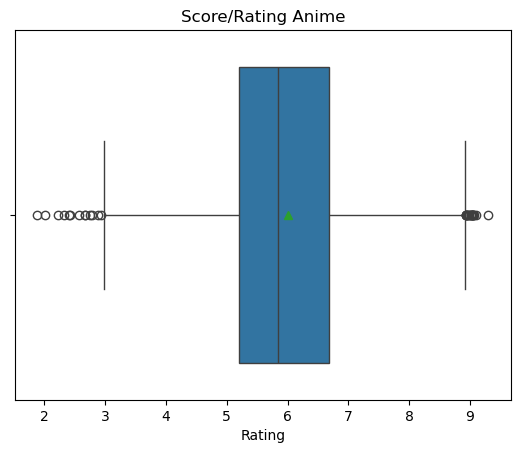

In [16]:
plt.figure()
sns.boxplot(data = df_update, x=df_update['score'], showmeans=True)
# sns.stripplot(data = df_update, x=df_update['score'], color ='k', jitter=0.18, alpha =0.25)
plt.title('Score/Rating Anime')
plt.xlabel('Rating')
plt.show()

The median anime rating appears to be around 5.8 and the mean rating around 6.0.

##### U.2 Visualize the rating distribution using a histplot

Text(0.5, 0, 'Rating')

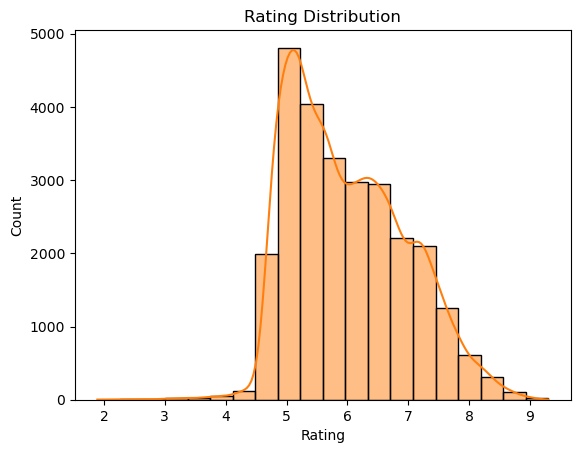

In [17]:
sns.histplot(df_update['score'].dropna(), bins=20, kde=True, color='C1')
plt.title('Rating Distribution')
plt.xlabel('Rating')

The most frequent rating value appears to be 5. This matches the earlier boxplot showing mean and median near 5.

##### U.3 Visualize the most popular `genres` using a barplot

C:\Users\ACER\AppData\Local\Temp\ipykernel_22812\1161461652.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=genre_counts.values, y=genre_counts.index, palette="viridis")


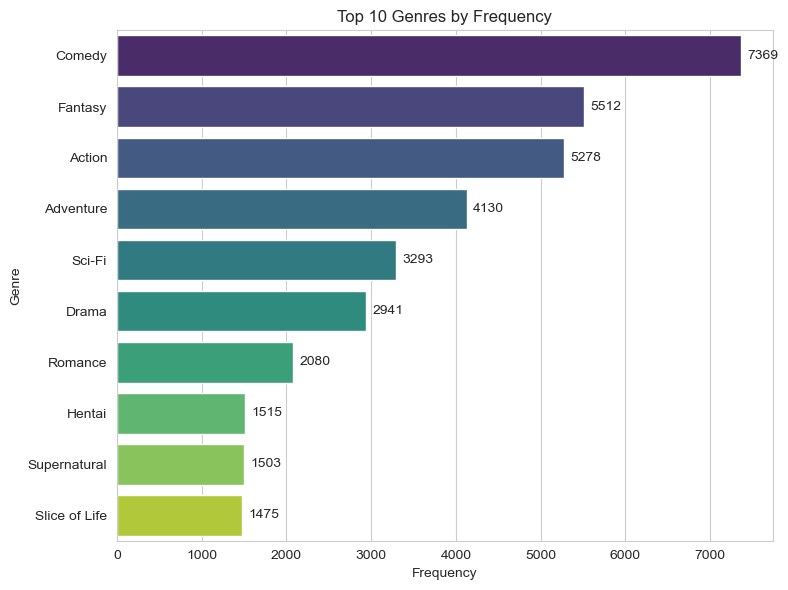

In [18]:
# Plot top 10 genres (horizontal bar chart)
# Uses existing df_update and df_genres_encoded variables from the notebook.

# Determine genre columns (prefer df_genres_encoded if available)
if 'df_genres_encoded' in globals():
    genre_cols = df_genres_encoded.columns.tolist()
else:
    # fallback: pick binary columns (0/1) in df_update
    genre_cols = [c for c in df_update.columns if df_update[c].dropna().isin([0, 1]).all() and df_update[c].dtype in (np.int64, np.int32, np.int8)]

# Compute top 10 genres by frequency
genre_counts = df_update[genre_cols].sum().sort_values(ascending=False).head(10)
# Reverse so largest appears at top in a horizontal bar chart

# Plot
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x=genre_counts.values, y=genre_counts.index, palette="viridis")
ax.set_xlabel("Frequency")
ax.set_ylabel("Genre")
ax.set_title("Top 10 Genres by Frequency")

# Annotate counts on bars
max_val = genre_counts.values.max()
for i, v in enumerate(genre_counts.values):
    ax.text(v + max_val * 0.01, i, f"{int(v)}", va='center')

plt.tight_layout()
plt.show()

Comedy appears to be the most popular genre among anime.

#### 2.1.2 Bivariate Visualization
##### B.1 Visualize `score` vs `members` using a scatterplot

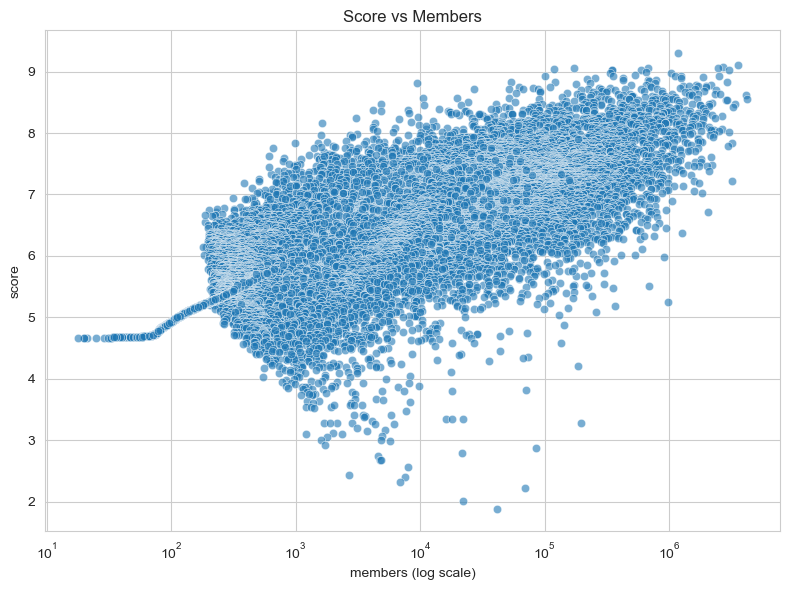

In [19]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_update, x='members', y='score', alpha=0.6)
plt.xscale('log')
plt.xlabel('members (log scale)') # setiap kolom naik sebanyak *10^1 (skala logaritmik)
plt.title('Score vs Members')
plt.tight_layout()
plt.show()

We observe that as the number of `members` increases, the `score` tends to increase as well. This suggests that a strong fanbase can boost an anime's rating.

##### B.2 Visualize `airing_category` vs `score` using a boxplot

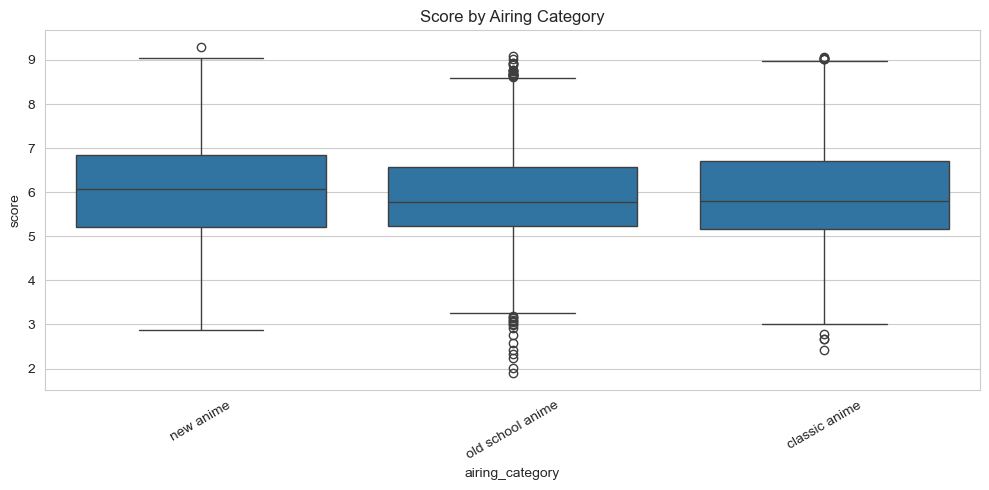

In [20]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df_update, x='airing_category', y='score')
plt.title('Score by Airing Category')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

Old-school anime (before 2010) show the most outliers, indicating higher variance in ratings for older titles.

##### B.3 Visualize correlations among `score`, `members`, `scored_by`, `popularity`, and `favorited` using a heatmap

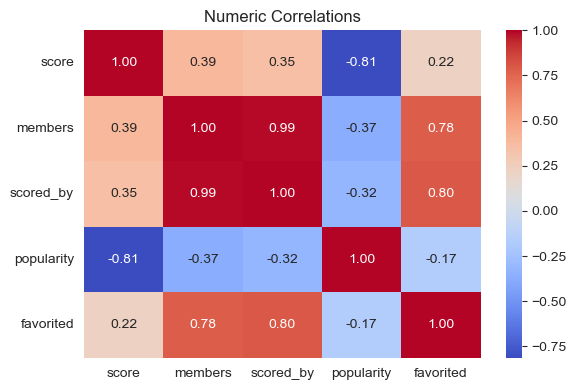

In [21]:
num_cols = ['score','members','scored_by','popularity', 'favorited']
num_cols = [c for c in num_cols if c in df_update.columns]
if len(num_cols) > 1:
    plt.figure(figsize=(6,4))
    sns.heatmap(df_update[num_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Numeric Correlations')
    plt.tight_layout()
    plt.show()

There is a very strong correlation (0.99) between `scored_by` and `members`, indicating larger fanbases generate more ratings. Interestingly, `popularity` and `score` appear inversely related, which is counterintuitive since higher popularity often corresponds to higher scores.

#### 2.1.3 Time Series Visualization
##### T.1 Visualize the number of anime releases per year using a lineplot

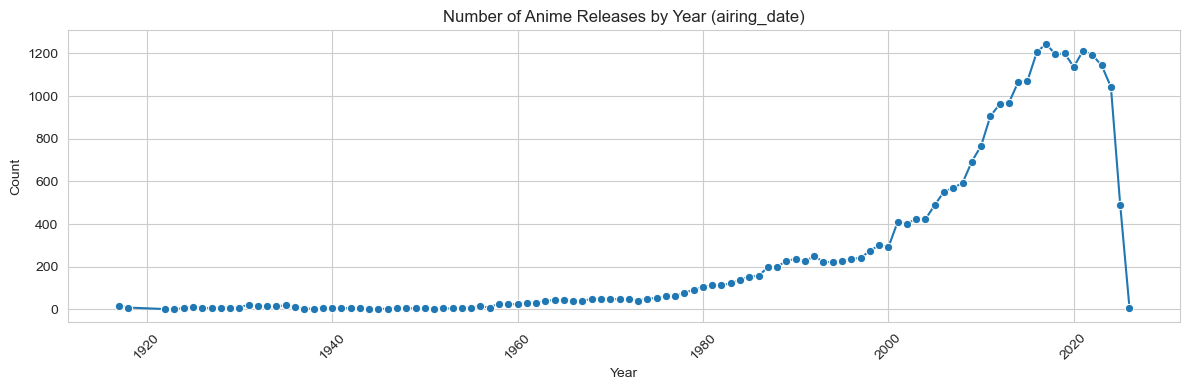

In [22]:
year_counts = df_update['airing_date'].dt.year.dropna().astype(int).value_counts().sort_index()
plt.figure(figsize=(12,4))
sns.lineplot(x=year_counts.index, y=year_counts.values, marker='o')
plt.title('Number of Anime Releases by Year (airing_date)')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The number of anime produced per year shows an increasing trend, suggesting growing popularity over time.

##### T.2 Visualize average score (rating) per year using a lineplot

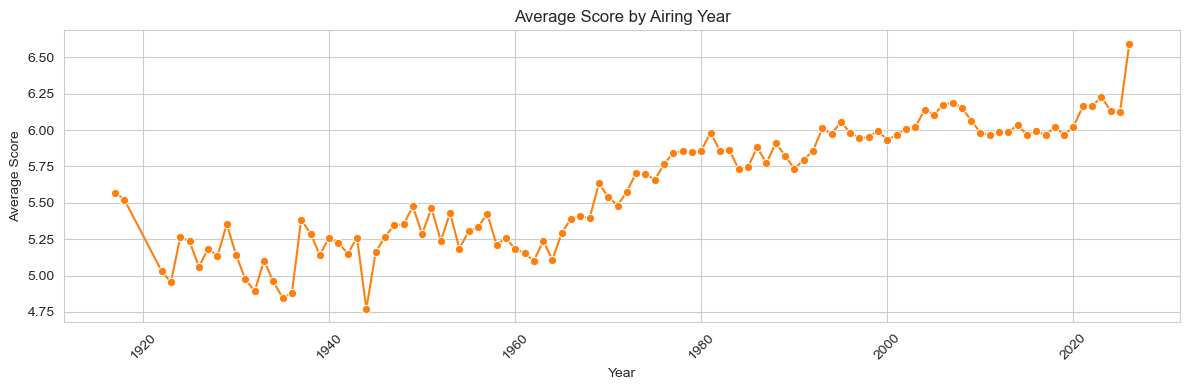

In [23]:
avg_score_by_year = df_update.groupby(df_update['airing_date'].dt.year.dropna().astype(int))['score'].mean()
plt.figure(figsize=(12,4))
sns.lineplot(x=avg_score_by_year.index, y=avg_score_by_year.values, marker='o', color='C1')
plt.title('Average Score by Airing Year')
plt.xlabel('Year')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The average anime score per year lacks a clear pattern, though there is a modest upward trend from the late 20th century into the 21st century.

## 3. Modelling Regression

I will use two boosting algorithms: **XGBoost** (Extreme Gradient Boosting) and **AdaBoost** (Adaptive Boosting).
XGBoost and AdaBoost are used to predict the `ranked` column using features: `score`, `popularity`, `members`, `favorited`, and the one-hot encoded `genre` columns. The `scored_by` feature is not used for training because it has a very high correlation (0.99) with `members`.
Evaluation metrics: MAE, RMSE, and R^2.

In [24]:
# 1) Prepare data for modelling
from sklearn.model_selection import train_test_split # to split train and test datasets
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # for regression evaluation
import numpy as np
import pandas as pd

# Make sure df_update exists
print('df_update rows, cols ->', df_update.shape)

# Numeric features as independent variables (predictors)
base_features = ['score','popularity','members','favorited']

# Identify genre one-hot columns. Prefer df_genres_encoded if available.
genre_cols = [c for c in df_genres_encoded.columns if c in df_update.columns]
print('Found', len(genre_cols), 'genre columns (examples):', genre_cols[:10])

# Compose feature matrix
features = [f for f in base_features if f in df_update.columns] + genre_cols
X = df_update[features].copy()
y = df_update['ranked'].astype(float).copy()

# If there are any non-numeric columns in X (shouldn't be), coerce to numeric
for col in X.columns:
    if not np.issubdtype(X[col].dtype, np.number):
        X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)

# Train-test split (20% as test data, the rest (80%) as train data). Using seed 42 for reproducibility.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

df_update rows, cols -> (26900, 43)
Found 21 genre columns (examples): ['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Boys Love', 'Comedy', 'Drama', 'Ecchi', 'Erotica', 'Fantasy']
Train shape: (21520, 25) Test shape: (5380, 25)


In [25]:
# 2) Train and evaluate models: XGBoost & AdaBoost
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

XGBRegressor = xgb.XGBRegressor
xgb_available = True

# variables to store model evaluation results
results = {}

# --- XGBoost ---
if xgb_available:
    model_xgb = XGBRegressor(random_state=42, n_estimators=200, verbosity=0) # hyperparameter
    model_xgb.fit(X_train, y_train)
    preds_xgb = model_xgb.predict(X_test)
    results['XGBoost'] = {
        'MAE': mean_absolute_error(y_test, preds_xgb),
        'RMSE': np.sqrt(mean_squared_error(y_test, preds_xgb)),
        'R2': r2_score(y_test, preds_xgb)
    }
    print('XGBoost done')
else:
    print('Skipping XGBoost because it is not available.')

# --- AdaBoost (with DecisionTree base) ---
base = DecisionTreeRegressor(max_depth=4, random_state=42) # hyperparameter decision tree sebagai basis adaboost
model_ada = AdaBoostRegressor(estimator=base, n_estimators=200, random_state=42) # hyperparameter adaboost
model_ada.fit(X_train, y_train)
preds_ada = model_ada.predict(X_test)
results['AdaBoost'] = {
    'MAE': mean_absolute_error(y_test, preds_ada),
    'RMSE': np.sqrt(mean_squared_error(y_test, preds_ada)),
    'R2': r2_score(y_test, preds_ada)
}
print('AdaBoost done')

# display results in a DataFrame 
res_df = pd.DataFrame(results).T
res_df = res_df[['MAE','RMSE','R2']]
print('Evaluation results on test set:')
display(res_df.round(4))

XGBoost done
AdaBoost done
Evaluation results on test set:
AdaBoost done
Evaluation results on test set:


,MAE,RMSE,R2
XGBoost,1139.4654,2015.4193,0.9394
AdaBoost,1906.1992,2707.4536,0.8906


XGBoost appears to perform better than AdaBoost, showing lower MAE and RMSE and a higher R^2, indicating it models the relationship between features and the target more effectively.

In [26]:
# 3) Multilinear Regression (LinearRegression) untuk prediksi 'ranked'
from sklearn.linear_model import LinearRegression
# Pastikan X_train, X_test, y_train, y_test sudah tersedia dari sel sebelumnya
model_lin = LinearRegression()
model_lin.fit(X_train, y_train)
preds_lin = model_lin.predict(X_test)
mae_lin = mean_absolute_error(y_test, preds_lin)
rmse_lin = np.sqrt(mean_squared_error(y_test, preds_lin))
r2_lin = r2_score(y_test, preds_lin)

# Tampilkan hasil evaluasi
res_lin = pd.DataFrame({
    'MAE': [mae_lin],
    'RMSE': [rmse_lin],
    'R2': [r2_lin]
}, index=['LinearRegression'])
print('Multilinear Regression evaluation on test set:')
display(res_lin.round(4))

Multilinear Regression evaluation on test set:


,MAE,RMSE,R2
LinearRegression,1864.1296,2838.4713,0.8797


For comparison, I also trained a Multilinear Regression model, which underperformed relative to XGBoost. Although it achieved a slightly lower MAE than AdaBoost in this run, its higher RMSE indicates greater variance. 

Overall, XGBoost provides the most reliable performance for modeling the relationship between `score`, `scored_by`, `popularity`, `members`, `favorited`, and the one‑hot encoded `genre` features versus the ranked target; AdaBoost is a reasonable second choice, and Multilinear Regression performs worst.